In [1]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 100
num_epochs = 100
lr = 0.001
num_outputs = 5
batch_size = 300
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
#criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=num_outputs,ys=y))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2112005


In [3]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, in_features, num_classes=num_outputs,std_variation=std_variation)

| epoch   0 | lr 0.0002 || validation loss 1.778
| epoch  10 | lr 0.0009901899829374047 || validation loss 1.444
| epoch  20 | lr 0.000931628240478787 || validation loss 1.156
| epoch  30 | lr 0.0008262928807620843 || validation loss 1.068
| epoch  40 | lr 0.0006855986244591103 || validation loss 0.988
| epoch  50 | lr 0.0005247918773366112 || validation loss 0.933
| epoch  60 | lr 0.00036129854561907783 || validation loss 0.908
| epoch  70 | lr 0.0002128356686585282 || validation loss 0.881
| epoch  80 | lr 9.549150281252633e-05 || validation loss 0.860
| epoch  90 | lr 2.198210923282118e-05 || validation loss 0.848
training completed in 395.29 seconds


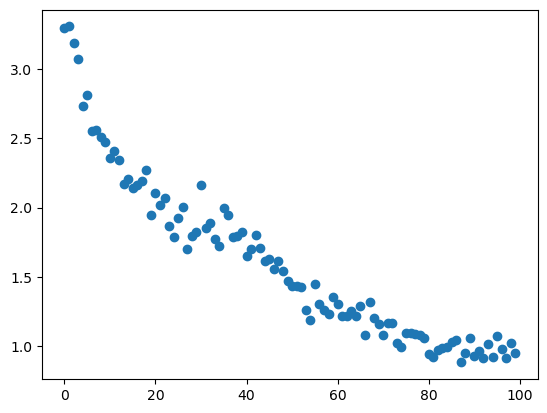

In [4]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

In [7]:
%matplotlib inline
temp_batch_size = 10
std_variation = True
random_seed = 42
train_X, train_Y, y_target_noisy, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,num_classes=num_outputs, kmeans=True,std_variation = std_variation) 
model.eval() 
print("")

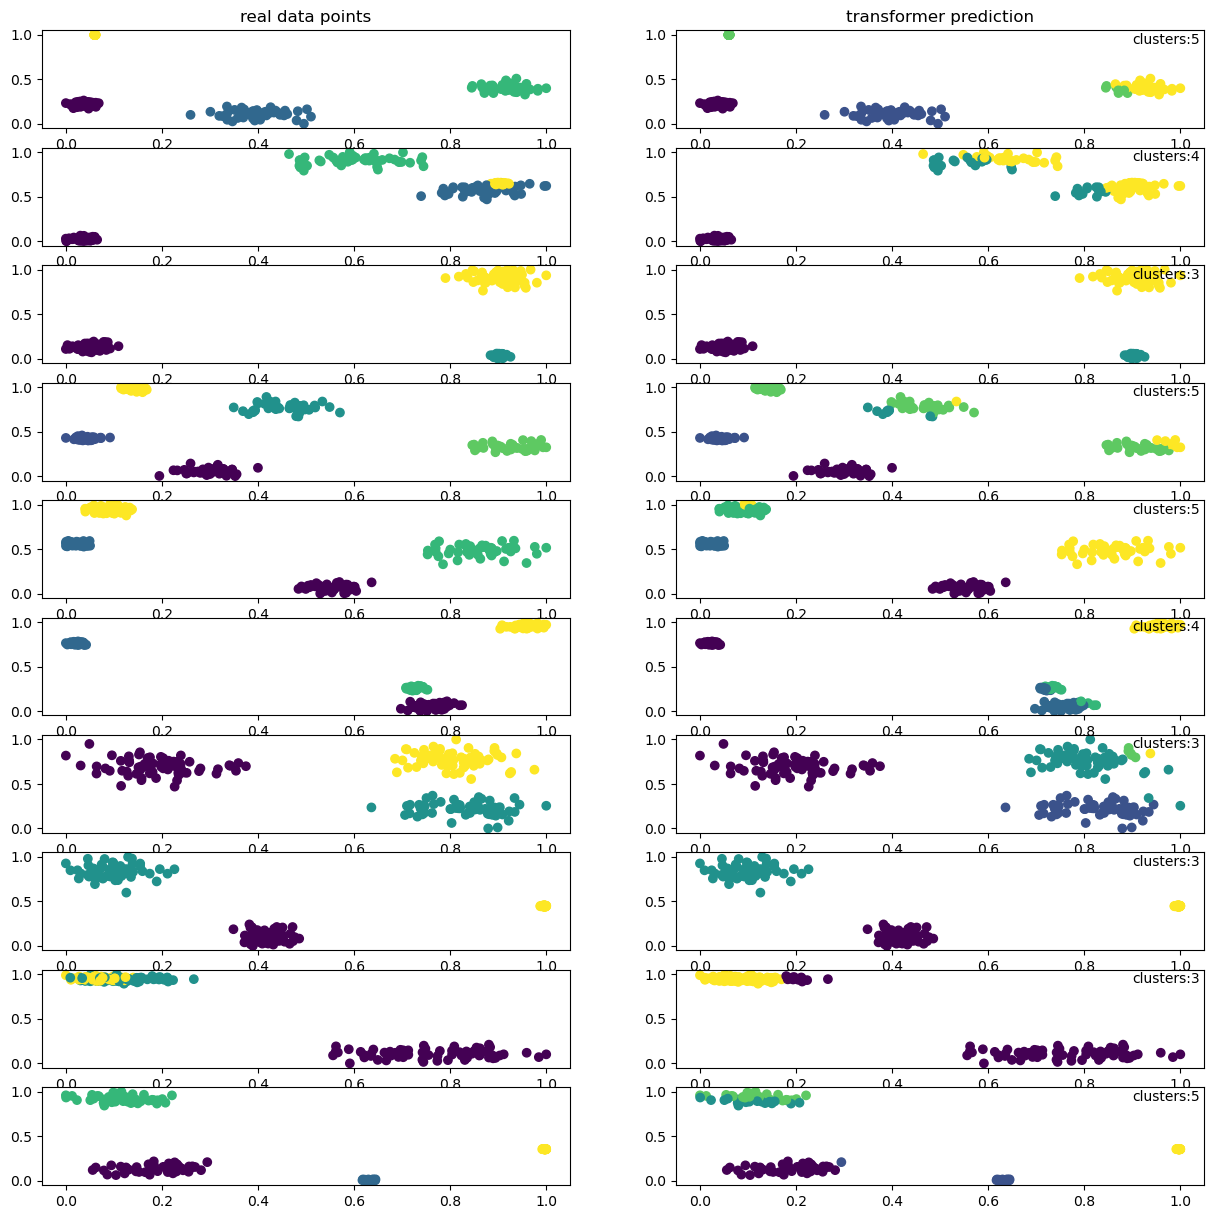

In [8]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 15)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[2 * batch_index + 1].text(0.9, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()